In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import Ridge,RidgeCV
from sklearn.metrics import mean_squared_error
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures

In [2]:
#导入数据
df=pd.read_csv(r"D:\jupyter_file\多输出模型\多输出模型(处理异常值).csv",encoding="gbk")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    801 non-null    object
 1   短租车次    801 non-null    int64 
 2   分时订单    801 non-null    int64 
 3   短租RP    801 non-null    int64 
 4   分时单均收入  801 non-null    int64 
 5   运营车次    801 non-null    int64 
 6   消费会员    801 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 43.9+ KB


In [3]:
print(sum(df.duplicated()))
df.drop(columns=['date'],inplace=True)

0


In [15]:
#计算vif
y,X=dmatrices('短租车次~短租RP+分时单均收入+运营车次+消费会员',df,return_type='dataframe')

vif=pd.DataFrame()
vif['VIF Factor']=[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['feature']=X.columns
vif

,VIF Factor,feature
0,50.175512,Intercept
1,1.719477,短租RP
2,1.316488,分时单均收入
3,2.515452,运营车次
4,2.137046,消费会员


输入变量之间vif小于5，可认为无共线性

In [5]:
#创建多项式
poly=PolynomialFeatures(3)
y_index=df.columns[:2]
x_index=df.columns[2:]
X_poly=poly.fit_transform(df[x_index])

In [6]:
#数据标准化
scaler=StandardScaler()
X_s=scaler.fit_transform(X_poly)

#拆分数据
x_train,x_test,y_train,y_test=model_selection.train_test_split(X_s,df[y_index],
                                                               test_size=0.2,random_state=1234)

In [7]:
#拟合模型
def ridge_model(x_train,y_train,x_test,y_test):
    
    #网格搜索alpha
    Lambdas=np.logspace(-5,2,200)
    ridge_cv=RidgeCV(alphas=Lambdas,normalize=True,scoring='neg_mean_squared_error',cv=10)
    ridge_cv.fit(x_train,y_train)
    print("最佳alpha：{}".format(ridge_cv.alpha_))
    
    #创建岭回归模型
    ridge=Ridge(alpha=ridge_cv.alpha_)
    ridge.fit(x_train,y_train)
    print("score：{}".format(ridge.score(x_test,y_test)))
    return ridge

In [8]:
#对短租车次创建模型
ridge=ridge_model(x_train,y_train[y_index[0]],x_test,y_test[y_index[0]])
ridge_pred=ridge.predict(x_test)

最佳alpha：0.00012315506032928262
score：0.9297140659948467


In [9]:
#画图比较预测值与实际值
def draw_picture(y_test,y_pred):
    plt.rcParams['figure.figsize'] = (20, 12)
    plt.xticks([]) 
    plt.yticks([]) 
    plt.plot(np.arange(len(y_test)),y_pred,color="r",label="预测值")
    plt.plot(np.arange(len(y_test)),y_test,color="k",label="实际值")
    plt.legend()

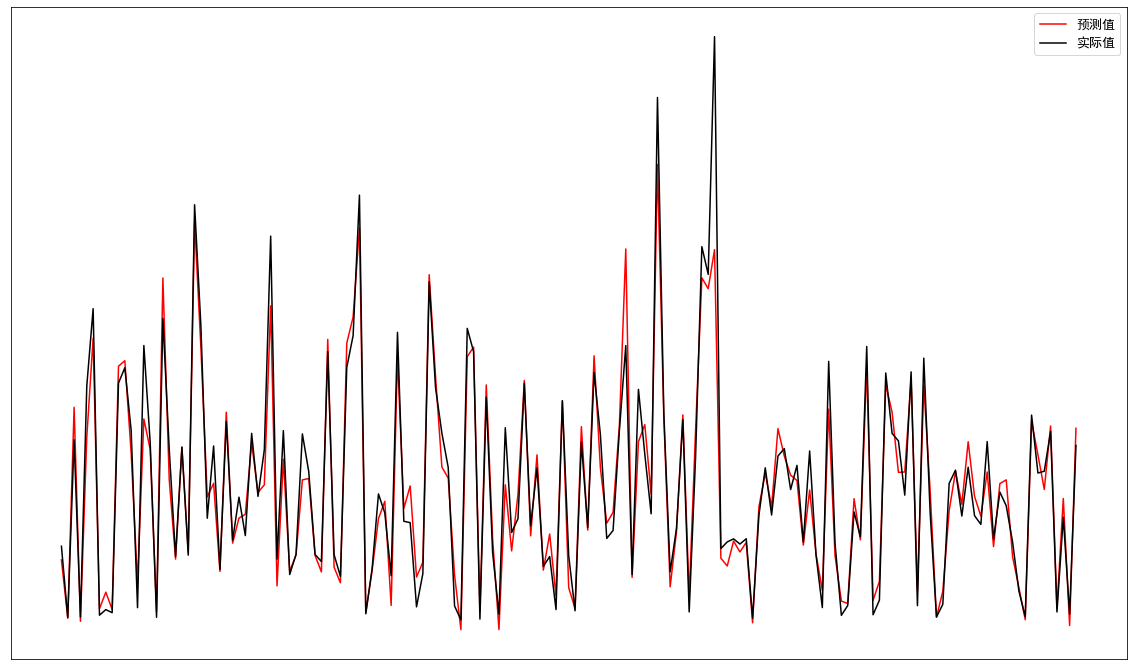

In [10]:
draw_picture(y_test[y_index[0]],ridge_pred)

最佳alpha：0.002899422853882875
score：0.9873224065747345


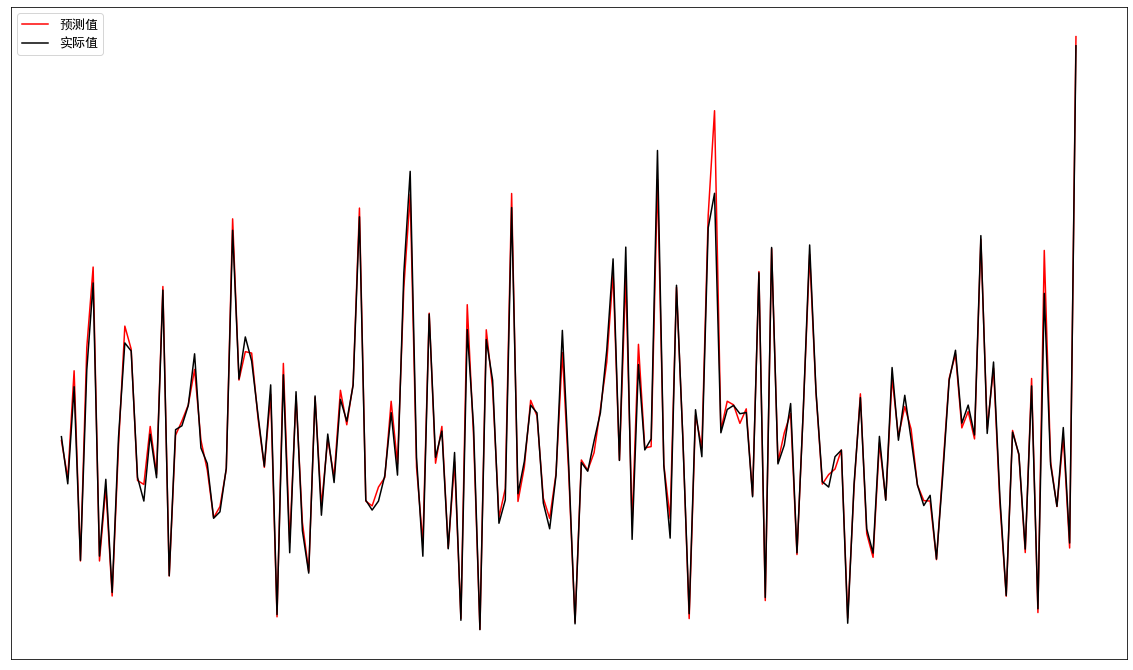

In [11]:
#对分时订单创建模型
ridge_=ridge_model(x_train,y_train[y_index[1]],x_test,y_test[y_index[1]])
ridge_pred_=ridge_.predict(x_test)

draw_picture(y_test[y_index[1]],ridge_pred_)